In [1]:
# Parameters
YEAR = 2024
SAVE_OUTPUT = True


In [2]:
# parameters
INPUT_DATA_PATH = "../data/interim/"
INPUT_PROCESSED_DATA_PATH = "../data/processed/"

YEAR = 2024
SAVE_OUTPUT = True
OUTPUT_DATA_PATH = "../data/processed/"
OUTPUT_FIGURES_PATH = "../reports/figures/"

In [3]:
# Import all necessary libraries
import time
start = time.time()
import geopandas as gpd
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import seaborn as sns

import warnings
from pathlib import Path


# Load data

In [4]:
# Read expansion factors from the input path
hod_weekday = pd.read_parquet(Path(INPUT_DATA_PATH) / f"expansion_factors/hod_weekday_{YEAR}.parquet")
hod_weekend = pd.read_parquet(Path(INPUT_DATA_PATH) / f"expansion_factors/hod_weekend_{YEAR}.parquet")
dow_factor = pd.read_parquet(Path(INPUT_DATA_PATH) / f"expansion_factors/dow_factor_{YEAR}.parquet")
moy_factor = pd.read_parquet(Path(INPUT_DATA_PATH) / f"expansion_factors/moy_factor_{YEAR}.parquet")
print(hod_weekday.columns)

Index(['id', 'year', 'hour', 'Average_HOD', 'sum_of_Average_HOD', 'HOD'], dtype='object')


In [5]:
bicizen = gpd.read_parquet(Path(INPUT_DATA_PATH) / f"bicizen/bicizen.parquet")
print(bicizen.shape)
print(bicizen.columns)

(722, 10)
Index(['ROOT_ID', 'Date', 'Hour', 'Count', 'date', 'Year', 'Month', 'weekday',
       'Day', 'geometry'],
      dtype='object')


# Filter data

In [6]:
## Only keep months with more than 10 observations

mask1 = bicizen.groupby(by=["ROOT_ID","Month"]).size() >= 10
bicizen = bicizen[bicizen.set_index(["ROOT_ID","Month"]).index.map(mask1)]
print("BiciZen shape before Mask 2", bicizen.shape)

print(bicizen.shape)


BiciZen shape before Mask 2 (553, 10)
(553, 10)


# Apply Expansion factors to Short Term Counts


The code is based on what Mintu et al did on their paper. Concretely:
* The first step in covered in the notebook: **SC_data_Imputation_Daily_Volume_v3.ipynb**
* The rest of the steps are covered in the notebook: **Weekly_Annual_Volume_Estimation_Version3.ipynb**

This research developed HOD, DOW, and MOY expansion factors to impute the short-term site volume to AADBT. The imputation factor can be implemented using five sequential steps, as shown in Figure 4. To apply the expansion factors, each short-term site should collect at least one hour of bicycle traffic or volume. 

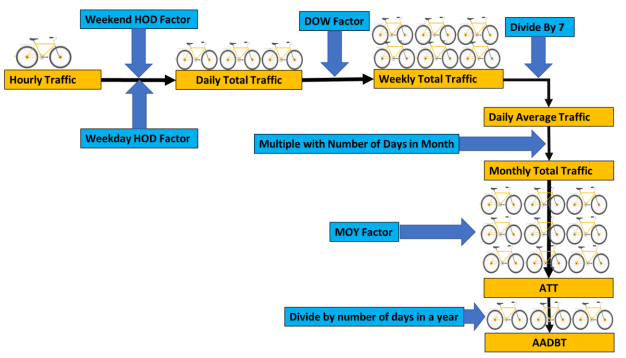

## Apply Expansion Factors

### Step 0: Prepare data

In [7]:
# #Concat the two datasets
# counts=pd.concat([bicizen,bacc])
# print(counts.shape)
# print(counts.columns)
# counts.head()
counts=bicizen


In [8]:
counts_weekday = counts[counts["weekday"]<5]
counts_weekend = counts[counts["weekday"]>4]

### Step 1: Apply weekday and weekend HOD factor

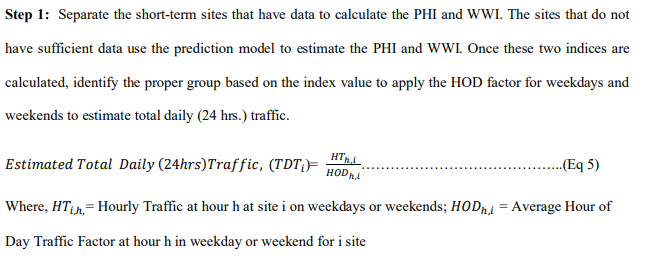

In [9]:
# Calculate daily Volume for weekday
# Merge counts_weekday data with hod_weekday factors on Year and Hour
merged_weekday_data = pd.merge(counts_weekday, hod_weekday, left_on=['Year', 'Hour'], right_on=['year', 'hour'], how='inner')

# Calculate total counts for each day and ROOT_ID
weekday_daily_counts = pd.DataFrame({'total_count': merged_weekday_data.groupby(['Year', 'Month', 'Day','weekday',  'ROOT_ID'])['Count'].sum()}).reset_index()

# Calculate total HOD factors for each day and ROOT_ID
weekday_daily_factors = pd.DataFrame({'total_factor': merged_weekday_data.groupby(['Year', 'Month', 'Day','weekday',  'ROOT_ID'])['HOD'].sum()}).reset_index()

# Merge the counts and factors dataframes
merged_weekday_counts_factors = pd.merge(weekday_daily_counts, weekday_daily_factors, on=['Year', 'Month', 'Day','weekday',  'ROOT_ID'], how='inner')

# Calculate the Daily Volume by dividing total counts by total factors
merged_weekday_counts_factors['Daily_Volume'] = merged_weekday_counts_factors['total_count'] / merged_weekday_counts_factors['total_factor']

# Calculate the mean Daily Volume (TDV) for each Year, ROOT_ID, Month, and Day
weekday_daily_volume = pd.DataFrame({'TDV': merged_weekday_counts_factors.groupby(['Year', 'ROOT_ID', 'Month','weekday',  'Day'])['Daily_Volume'].mean()}).reset_index()

weekday_daily_volume

,Year,ROOT_ID,Month,weekday,Day,TDV
0,2024,1029389,11,0,11,3055.082444
1,2024,1029389,11,0,18,4246.958657
2,2024,1029389,11,0,25,1086.213200
3,2024,1029389,11,1,5,2696.936840
4,2024,1029389,11,1,19,4073.299500
...,...,...,...,...,...,...
341,2024,1059225,11,3,21,407.329950
342,2024,1059225,11,3,28,543.106600
343,2024,1059225,11,4,15,245.239661
344,2024,1059225,11,4,22,543.106600


In [10]:
# Calculate daily Volume for weekend
# Merge counts_weekend data with hod_weekend factors on Year and Hour
merged_weekend_data = pd.merge(counts_weekend, hod_weekend, left_on=['Year', 'Hour'], right_on=['year', 'hour'], how='inner')

# Calculate total counts for each day and ROOT_ID
weekend_daily_counts = pd.DataFrame({'total_count': merged_weekend_data.groupby(['Year', 'Month', 'Day', 'weekday', 'ROOT_ID'])['Count'].sum()}).reset_index()

# Calculate total HOD factors for each day and ROOT_ID
weekend_daily_factors = pd.DataFrame({'total_factor': merged_weekend_data.groupby(['Year', 'Month', 'Day', 'weekday', 'ROOT_ID'])['HOD'].sum()}).reset_index()

# Merge the counts and factors dataframes
merged_weekend_counts_factors = pd.merge(weekend_daily_counts, weekend_daily_factors, on=['Year', 'Month', 'weekday', 'Day', 'ROOT_ID'], how='inner')

# Calculate the Daily Volume by dividing total counts by total factors
merged_weekend_counts_factors['Daily_Volume'] = merged_weekend_counts_factors['total_count'] / merged_weekend_counts_factors['total_factor']

# Calculate the mean Daily Volume (TDV) for each Year, ROOT_ID, Month, and Day
weekend_daily_volume = pd.DataFrame({'TDV': merged_weekend_counts_factors.groupby(['Year', 'ROOT_ID', 'Month', 'weekday', 'Day'])['Daily_Volume'].mean()}).reset_index()

weekend_daily_volume.head()

,Year,ROOT_ID,Month,weekday,Day,TDV
0,2024,1048268,11,5,2,567.995381
1,2024,1048268,11,5,9,495.767846
2,2024,1048268,11,5,16,294.262246
3,2024,1048268,11,5,23,307.824432
4,2024,1048268,11,5,30,553.001082


In [11]:
#Concat both datasets
daily_volume=pd.concat([weekday_daily_volume,weekend_daily_volume])
# daily_volume=weekday_daily_volume.copy()
print(daily_volume.shape)

(416, 6)


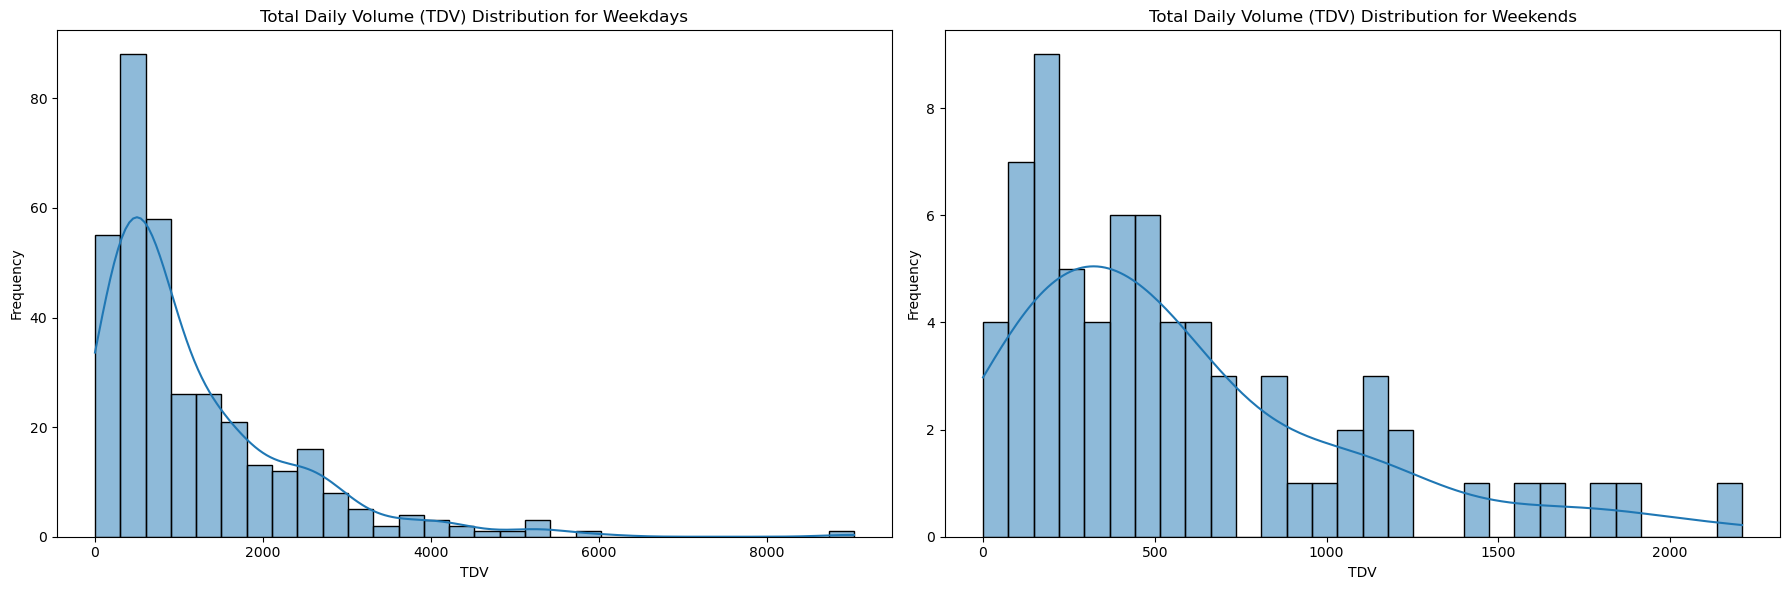

In [12]:
# Make plots of TDV for weekday and weekend side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot TDV for weekday
sns.histplot(weekday_daily_volume['TDV'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Total Daily Volume (TDV) Distribution for Weekdays')
axes[0].set_xlabel('TDV')
axes[0].set_ylabel('Frequency')

# Plot TDV for weekend
sns.histplot(weekend_daily_volume['TDV'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Total Daily Volume (TDV) Distribution for Weekends')
axes[1].set_xlabel('TDV')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Step 2: Apply DOW factor


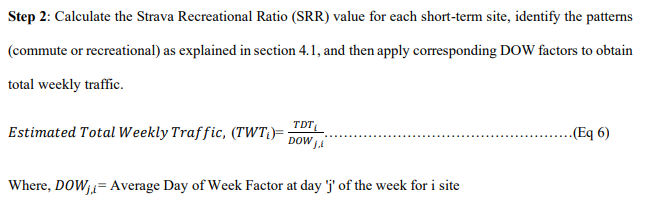

In [13]:
# Merge daily volume data with day of week (DOW) factors
merged_dow_data = pd.merge(daily_volume, dow_factor, on='weekday', how='inner')

# Aggregate weekly volume by summing daily volumes for each Year, ROOT_ID, and Month
weekly_volume_sum = merged_dow_data.groupby(['Year', 'ROOT_ID', 'Month'])['TDV'].sum().reset_index()
weekly_volume_sum.rename(columns={'TDV': 'total_weekly_volume'}, inplace=True)

# Aggregate DOW factors by summing them for each Year, ROOT_ID, and Month
weekly_dow_factor_sum = merged_dow_data.groupby(['Year', 'ROOT_ID', 'Month'])['DOW'].sum().reset_index()
weekly_dow_factor_sum.rename(columns={'DOW': 'total_dow_factor'}, inplace=True)

# Merge the weekly volume and DOW factor dataframes
merged_weekly_data = pd.merge(weekly_volume_sum, weekly_dow_factor_sum, on=['Year', 'ROOT_ID', 'Month'], how='inner')

# Calculate the weekly volume by dividing total weekly volume by total DOW factor
merged_weekly_data['Weekly_Volume'] = merged_weekly_data['total_weekly_volume'] / merged_weekly_data['total_dow_factor']

# Calculate the mean weekly volume (TWV) for each Year, ROOT_ID, and Month
mean_weekly_volume = merged_weekly_data.groupby(['Year', 'ROOT_ID', 'Month'])['Weekly_Volume'].mean().reset_index()
mean_weekly_volume.rename(columns={'Weekly_Volume': 'TWV'}, inplace=True)

mean_weekly_volume


,Year,ROOT_ID,Month,TWV
0,2024,1029389,11,19435.646048
1,2024,1046328,11,5062.057328
2,2024,1046333,11,1732.464571
3,2024,1046343,11,2732.300226
4,2024,1047953,11,18626.541362
5,2024,1047975,11,31826.289385
6,2024,1048209,11,13596.148172
7,2024,1048223,11,11946.118273
8,2024,1048268,11,3029.194935
9,2024,1048272,11,3960.309250


### Step 3: Divide by 7 to get ADBT

In [14]:
# Now divide TWV by 7 to get the weekly average volume
mean_weekly_volume['AWV'] = mean_weekly_volume['TWV'] / 7
mean_weekly_volume.head()

,Year,ROOT_ID,Month,TWV,AWV
0,2024,1029389,11,19435.646048,2776.520864
1,2024,1046328,11,5062.057328,723.151047
2,2024,1046333,11,1732.464571,247.494939
3,2024,1046343,11,2732.300226,390.328604
4,2024,1047953,11,18626.541362,2660.934480


In [15]:
mean_weekly_volume['AWV'].describe()

count      26.000000
mean     1164.798265
std      1034.684627
min        84.423280
25%       436.846399
50%       673.487804
75%      1835.334784
max      4546.612769
Name: AWV, dtype: float64

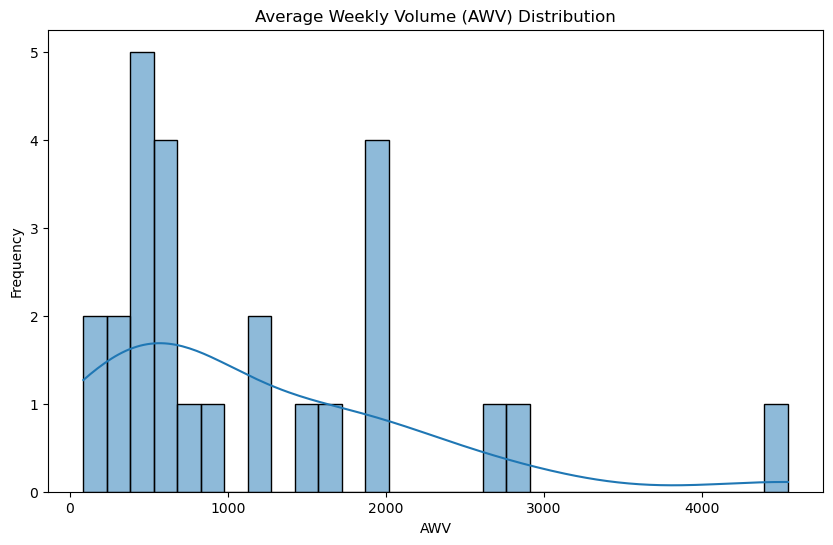

In [16]:
# Make a plot of AWV distribution
plt.figure(figsize=(10, 6))

# Plot AWV distribution
sns.histplot(mean_weekly_volume['AWV'], bins=30, kde=True)
plt.title('Average Weekly Volume (AWV) Distribution')
plt.xlabel('AWV')
plt.ylabel('Frequency')

plt.show()



### Step 4: Multiply by days of the month

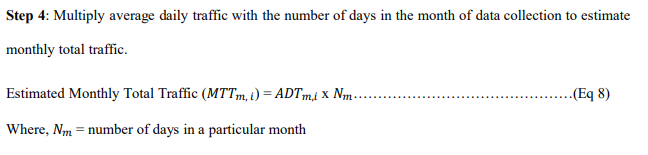

In [17]:
# Calculate the number of days in the data collection month and multiply average weekly volume (AWV) to get monthly total volume
# Create a dummy day column to get the date and days in the month
mean_weekly_volume['days_in_month'] = pd.to_datetime(mean_weekly_volume[['Year', 'Month']].assign(day=1)).dt.days_in_month

mean_monthly = mean_weekly_volume.groupby(['Year', 'Month','days_in_month', 'ROOT_ID'])['AWV'].sum().reset_index()
mean_monthly["MTT"] = mean_monthly.apply(lambda row: row["AWV"] * row["days_in_month"], axis=1)
# mean_monthly["MTT"].describe()

### Step 5: Apply MOY and divide by days in year

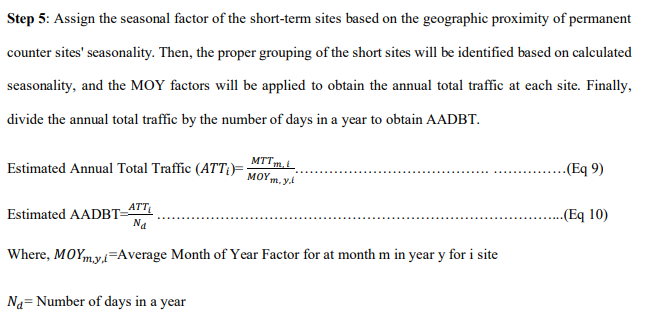

In [18]:
# Calculate Annual Volume for group 1
merged_group1 = pd.merge(mean_monthly, moy_factor[["month","MOY"]], left_on=['Month'], right_on=['month'], how='inner')

# Calculate aggregated monthly volume
agg_monthly_volume = pd.DataFrame({'agg_monthly_volume': merged_group1.groupby(['Year', 'ROOT_ID'])['MTT'].sum()}).reset_index()

# Calculate aggregated MOY factor
agg_moy_factor = pd.DataFrame({'agg_moy_factor': merged_group1.groupby(['Year', 'ROOT_ID'])['MOY'].sum()}).reset_index()

# Merge the aggregated data
merged_annual_data = pd.merge(agg_monthly_volume, agg_moy_factor, on=['Year', 'ROOT_ID'], how='inner')

# Calculate Annual Volume
merged_annual_data['Annual_Volume'] = merged_annual_data['agg_monthly_volume'] / merged_annual_data['agg_moy_factor']

# Calculate the mean Annual Volume (ATT)
annual_volume = pd.DataFrame({'ATT': merged_annual_data.groupby(['Year', 'ROOT_ID'])['Annual_Volume'].mean()}).reset_index()

annual_volume.head(5)


,Year,ROOT_ID,ATT
0,2024,1029389,903375.899687
1,2024,1046328,235286.266375
2,2024,1046333,80525.583573
3,2024,1046343,126998.308625
4,2024,1047953,865768.419524


In [19]:
# Convert ATT to millions
annual_volume['ATT_in_Million'] = annual_volume['ATT'] / 1000000

# Calculate AADBT
annual_volume['AADBT'] = annual_volume['ATT'] / 365

annual_volume.head()

,Year,ROOT_ID,ATT,ATT_in_Million,AADBT
0,2024,1029389,903375.899687,0.903376,2475.002465
1,2024,1046328,235286.266375,0.235286,644.619908
2,2024,1046333,80525.583573,0.080526,220.618037
3,2024,1046343,126998.308625,0.126998,347.940572
4,2024,1047953,865768.419524,0.865768,2371.968273


In [20]:
import plotly.express as px

# Create a histogram for AADBT distribution with 10 bins
fig = px.histogram(annual_volume, x='AADBT', nbins=10, title='Average Annual Daily Bicycle Traffic (AADBT) Distribution')
fig.update_layout(xaxis_title='AADBT', yaxis_title='Frequency')
fig.show()


## Results

In [21]:
annual_volume['AADBT'].describe()

count      26.000000
mean     1040.217100
std       920.491059
min        75.255269
25%       389.406732
50%       600.349883
75%      1636.025204
max      4052.869891
Name: AADBT, dtype: float64

In [22]:
import plotly.express as px

# Create a combined DataFrame for plotting
combined_df = pd.DataFrame({
    'Value': pd.concat([weekday_daily_volume['TDV'], weekend_daily_volume['TDV'], mean_weekly_volume['AWV'], annual_volume['AADBT']]),
    'Category': ['Weekday TDV'] * len(weekday_daily_volume) + ['Weekend TDV'] * len(weekend_daily_volume) + ['Weekly AWV'] * len(mean_weekly_volume) + ['Annual AADBT'] * len(annual_volume)
})


# Create the box plot
fig = px.box(combined_df, x='Category', y='Value', title='Box Plots of TDV, AWV, and AADBT made with BiciZen data')
fig.show() 

# Save output

In [23]:
# Save expansion factors separately
if SAVE_OUTPUT:
    annual_volume.to_parquet(Path(OUTPUT_DATA_PATH) / f"bicizen_aadbt{YEAR}.parquet")
    # Save the figure in OUTPUT_FIGURES_PATH
    fig.write_image(Path(OUTPUT_FIGURES_PATH) / f"bicizen_aadbt_distribution{YEAR}.png")


